In [1]:
from IPython.display import clear_output
!pip install mteb
!pip install -q transformers accelerate bitsandbytes
!pip install qpsolvers
!pip install hf_xet
!pip install --upgrade --pre numpy
clear_output()

In [1]:
import pickle
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import mteb

import torch
from transformers import AutoTokenizer, AutoModel
from mteb.encoder_interface import Encoder
from typing import List, Dict, Optional, Sequence
import torch.nn.functional as F

# from qpsolvers import solve_qp
import cvxpy as cp

import os, gc
import json
from tqdm.auto import tqdm
from datasets import load_dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

from sklearn.decomposition import IncrementalPCA
from sklearn.metrics.pairwise import cosine_similarity

(CVXPY) May 27 11:59:33 AM: Encountered unexpected exception importing solver HIGHS:
ValueError("invalid literal for int() with base 10: '0rc1'")
(CVXPY) May 27 11:59:33 AM: Encountered unexpected exception importing solver HIGHS:
ValueError("invalid literal for int() with base 10: '0rc1'")


In [2]:
def save_res(dct, path):
  with open(path, 'wb') as handle:
      pickle.dump(dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_res(path):
  try:
    with open(path, 'rb') as handle:
      results = pickle.load(handle)
  except:
    results = {}

  return results

DEVICE = torch.device('cuda')

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
MODEL_NAME = "bert-base-uncased"
BATCH_SIZE = 500
MAX_LEN    = 200
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
BASE_PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/'
#из схожести слоев
CLUSTERS = [[1, 2, 3], [4, 5, 6, 7, 8], [9, 10, 11, 12], [0]]

# Классы

In [4]:
class MultiLayerEncoderMean(Encoder):
    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        **agg_kwargs
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModel.from_pretrained(
                    model_name,
                    device_map="auto",
                  ).eval()
        self.agg_kwargs = agg_kwargs

    def encode(
        self,
        sentences: List[str],
        gpu_sub_batch = BATCH_SIZE,
        **kwargs
    ) -> torch.Tensor:

        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch_sents = sentences[start : start + gpu_sub_batch]

            inputs = self.tokenizer(
                batch_sents,
                padding=True,
                truncation=True,
                max_length = MAX_LEN,
                return_tensors="pt"
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)


            mask = inputs["attention_mask"].unsqueeze(-1)                     # [B,L,1]
            vecs = ((outs.last_hidden_state * mask).sum(1) / mask.sum(1)).cpu()

            all_vecs.append(vecs)

            # очистка памяти GPU
            # del outs, inputs
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)

In [5]:
def qadr_solve(acc, sim, lmbd=1.0):
    """
    acc  — numpy-массив [L], качество каждого слоя
    sim  — numpy-матрица [L x L], похожесть (CKA / RSA / corr)
    lmbd — коэффициент штрафа за дублирование (λ)

    Возвращает оптимальные веса слоёв [L], сумма = 1, все ≥ 0
    """
    acc = np.asarray(acc)
    sim = np.asarray(sim)
    L = len(acc)

    w = cp.Variable(L, nonneg=True)                       # веса ≥ 0
    objective = cp.Maximize(acc @ w - lmbd * cp.quad_form(w, sim))
    constraints = [cp.sum(w) == 1]                        # сумма = 1
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

In [8]:
from scipy.optimize import minimize

def qadr_solve_greedy(acc, sim, lmbd=1.0, alpha=1.0):
    n = len(acc)
    mask = (acc[None, :] > acc[:, None]).astype(float)
    A    = sim * mask
    np.fill_diagonal(A, alpha)      # самоподобие

    def obj(w, q, A, lam):
        pen  = w @ A @ w
        val  = -(q @ w - lam*pen)
        grad = -(q - lam * (A + A.T) @ w)
        return val, grad

    w0 = np.full(n, 1/n)
    cons = [{'type':'eq', 'fun':lambda w: w.sum()-1},
            {'type':'ineq','fun':lambda w: w}]
    res = minimize(lambda w,*a: obj(w,*a), w0, args=(acc,A,lmbd),
                   jac=True, method='SLSQP', constraints=cons)
    return res.x

In [9]:
def opt_full(a, corr_matrix, n = 6):
  """
  полная оптимизация из статьи Beyond simple average
  """
  P = 2 * corr_matrix
  c = np.diag(corr_matrix)
  q = a - c
  A = np.ones((1, corr_matrix.shape[0]))
  b = np.ones(1)
  lb = np.zeros(corr_matrix.shape[0])
  ub = np.ones(corr_matrix.shape[0])
  x_sol = solve_qp(P, q, A=A, b=b, lb=lb, ub=ub, initvals=np.ones(n)*1/n, solver='cvxopt', verbose=False)
  return x_sol

In [10]:
class MultiLayerEncoderWeighted(Encoder):
    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        layer_indices: List[int] = None,
        layer_weights: List[float] = None,
        **agg_kwargs
    ):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto",
        ).eval()
        self.agg_kwargs = agg_kwargs

        assert layer_indices is not None and layer_weights is not None, \
            "Нужно передать список слоёв и соответствующих весов"
        assert len(layer_indices) == len(layer_weights), "Длины layer_indices и layer_weights не совпадают"

        self.layer_indices = layer_indices
        self.layer_weights = torch.tensor(layer_weights, dtype=torch.float32)

    def encode(
        self,
        sentences: List[str],
        gpu_sub_batch=BATCH_SIZE,
        **kwargs
    ) -> torch.Tensor:

        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch_sents = sentences[start:start + gpu_sub_batch]

            inputs = self.tokenizer(
                batch_sents,
                padding=True,
                truncation=True,
                max_length = MAX_LEN,
                return_tensors="pt"
            ).to(self.model.device)

            with torch.no_grad():
                outputs = self.model(**inputs)
                hidden = outputs.hidden_states  # tuple of [B,L,H], len = 13

            mask = inputs["attention_mask"].unsqueeze(-1).to(torch.float32)  # [B,L,1]

            # собираем sentence embeddings с mean-pool для нужных слоёв
            layer_vecs = []
            for i in self.layer_indices:
                h = hidden[i]                             # [B,L,H]
                sent_vec = (h * mask).sum(1) / mask.sum(1)  # mean-pool
                layer_vecs.append(sent_vec)

            stacked = torch.stack(layer_vecs, dim=0)       # [num_layers, B, H]
            weights = self.layer_weights.to(stacked.device).view(-1, 1, 1)  # [num_layers,1,1]
            weighted = (stacked * weights).sum(0)          # [B, H]

            all_vecs.append(weighted.cpu())

            # del outputs, hidden, inputs, stacked, weighted
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)


In [11]:
def cluster_concat_pca(
    embeddings: torch.Tensor,          # [batch, layers, seq_len, dim]
    attention_mask: torch.Tensor,      # [batch, seq_len]
    weights: torch.Tensor,
    clusters: Sequence[Sequence[int]],
    pooling: str = "mean",
    pca_components: torch.Tensor = None,
    pca_mean: torch.Tensor = None,
):
    device, dtype = embeddings.device, embeddings.dtype
    weights = weights.to(device=device, dtype=dtype)
    cluster_vecs: List[torch.Tensor] = []

    # 1-2. среднее по слоям кластера + токен-pooling
    for cid, cl in enumerate(clusters):
        cl_avg = embeddings[:, cl, :, :].mean(dim=1)                # [B,L,H]
        if pooling == "cls":
            vec = cl_avg[:, 0, :]
        elif pooling == "mean":
            mask = attention_mask.unsqueeze(-1)                     # [B,L,1]
            vec = (cl_avg * mask).sum(1) / mask.sum(1)
        else:
            raise ValueError(f"Unknown pooling = {pooling}")

        vec = vec * weights[cid]
        cluster_vecs.append(vec)

    concat_vec = torch.cat(cluster_vecs, dim=-1)                    # [B, concat_dim]

    if pca_components is None:                                      # без проекции
        return concat_vec.to(dtype)

    # центрирование
    if pca_mean is not None:
        concat_vec = concat_vec - pca_mean.to(device, dtype)

    return (concat_vec @ pca_components.T.to(device, dtype))        # [B, out_dim]

In [12]:
class MultiLayerEncoder(Encoder):
    def __init__(
        self,
        clusters,
        pca_components,
        pca_mean,
        weights,
        pooling="mean",
        model_name="bert-base-uncased",
    ):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto"
        ).eval()

        self.clusters       = [list(cl) for cl in clusters]
        self.pca_components = pca_components          # Tensor CPU (можно .half())
        self.pca_mean       = pca_mean
        self.pooling        = pooling
        self.weights        = weights

    def encode(self, sentences, gpu_sub_batch=BATCH_SIZE, **kwargs):
        """Encode с автоматическим микро-батчингом."""
        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch_sents = sentences[start : start + gpu_sub_batch]

            inputs = self.tokenizer(
                batch_sents,
                padding=True,
                truncation=True,
                max_length = MAX_LEN,
                return_tensors="pt",
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)

            hidden = torch.stack(outs.hidden_states).permute(1, 0, 2, 3)
            vecs   = cluster_concat_pca(
                        hidden,
                        inputs["attention_mask"],
                        clusters       = self.clusters,
                        pooling        = self.pooling,
                        pca_components = self.pca_components,
                        pca_mean       = self.pca_mean,
                        weights = self.weights
                     ).cpu()         # сразу на CPU, чтобы освободить GPU

            all_vecs.append(vecs)

            # очистка памяти GPU
            # del outs, hidden, inputs
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)

In [13]:
def greedy_layer_selection(q, S, lmbd=0.5, top_n=None):
    """
    Жадный выбор лучших top_n слоёв по качеству и разнообразию.

    Аргументы:
        q      : (L,) массив качеств слоёв
        S      : (L, L) матрица похожестей слоёв (CKA, RSA и т.п.)
        lmbd   : баланс между качеством и разнообразием
        top_n  : сколько слоёв выбрать (обязательный параметр)

    Возвращает:
        selected_layers,: список индексов выбранных слоёв (в порядке выбора)
        weights        : нормализованные веса слоёв (0 для неиспользуемых)
    """
    assert top_n is not None and top_n > 0, "top_n должен быть задан явно"

    q = np.array(q, dtype=np.float32)
    S = np.array(S, dtype=np.float32)
    L = len(q)

    selected = []
    remaining = set(range(L))
    # weights = np.zeros(top_n, dtype=np.float32)

    for step in range(top_n):
        best_gain = -np.inf
        best_idx = None

        for i in remaining:
            gain_quality = q[i]
            penalty = np.mean([S[i][j] for j in selected]) if selected else 0.0
            gain = gain_quality - lmbd * penalty

            if gain > best_gain:
                best_gain = gain
                best_idx = i

        if best_idx is None:
            break

        selected.append(best_idx)
        remaining.remove(best_idx)

    # Назначаем веса: чем раньше выбран слой, тем выше вес
    rank_weights = np.array([1.0 / (i + 1) for i in range(len(selected))], dtype=np.float32)
    rank_weights /= rank_weights.sum()

    return selected, rank_weights


In [14]:
def greedy_layer_selection_v2(
    q: np.ndarray,
    S: np.ndarray,
    *,
    lmbd: float = 0.5,
    max_n: int | None = None,
    min_gain: float = 0.0,
    norm: str = "minmax"
):
    """Greedy + веса = нормированные приросты gain."""
    # --- нормализация метрик (как раньше) --------------------
    q = np.asarray(q, np.float32)
    if norm == "minmax":
        q = (q - q.min()) / (q.max() - q.min() + 1e-9)
    elif norm == "zscore":
        z = (q - q.mean()) / (q.std() + 1e-9)
        q = (z - z.min()) / (z.max() - z.min() + 1e-9)
    elif norm == "baseline":
        base = q[-1]; q = np.maximum((q - base) / (abs(base) + 1e-9), 0.0)
    elif norm != "none":
        raise ValueError("unknown norm")

    S = np.asarray(S, np.float32)
    selected, gains = [], []          # сохраним приросты
    remaining = set(range(len(q)))
    step = 0

    while remaining and (max_n is None or step < max_n):
        best_gain, best_idx = -np.inf, None
        for i in remaining:
            penalty = np.mean([S[i, j] for j in selected]) if selected else 0.0
            gain    = q[i] - lmbd * penalty
            # print(q[i],  lmbd * penalty)
            if gain > best_gain:
                best_gain, best_idx = gain, i
        # print(best_idx)
        # print('*'*100)

        if best_gain < min_gain:
            break                     # ранний стоп

        selected.append(best_idx)
        gains.append(best_gain)       # фиксируем прирост
        remaining.remove(best_idx)
        step += 1

    # --- веса из gain ----------------------------------------
    gains = np.array(gains, dtype=np.float32)
    if gains.sum() == 0:
        weights = np.ones_like(gains) / len(gains)      # fallback
    else:
        weights = gains / gains.sum()                   # нормируем в 1.0

    return selected, weights


In [15]:
def greedy_layer_selection_v3(
    q: np.ndarray,
    S: np.ndarray,
    *,
    lmbd: float = 0.5,          # баланс «качество — разнообразие»
    drop_delta: float = 0.15,   # отсекаем слои, у которых quality
                                # < (1-drop_delta)·q_max
    max_n: int | None = None,   # жёстный максимум (None → без потолка)
):
    """
    1. Удаляем все слои, чьё «качество» хуже чем на `drop_delta·100 %`
       от лучшего (raw-метрики, без нормировки).
    2. На оставшихся выполняем greedy-алгоритм
       (quality − λ·similarity) с нормировкой quality → [0,1].
    3. Веса = ранговые (1, 1/2, 1/3 …) и нормируются до 1.0.

    Параметры
    ---------
    q : (L,)  массив исходных (ненормированных) качеств слоёв
    S : (L,L) матрица похожести (0 … 1, меньше = разнообразнее)
    lmbd       : вес penalty
    drop_delta : доля ухудшения от лучшего, ниже которой слой отбрасывается
                 (0.15 ⇒ берём только те, что ≥ 85 % max(q))
    max_n      : максимум слоёв после фильтра. None ⇒ без ограничения

    Возврат
    -------
    selected : list[int]     индексы выбранных слоёв
    weights  : np.ndarray    ранговые веса, сумма = 1
    """

    q_raw = np.asarray(q, np.float32)
    S     = np.asarray(S, np.float32)

    # --- 1. Фильтр по качеству -----------------------------------------
    q_max = q_raw.max()
    keep  = np.where(q_raw >= (1.0 - drop_delta) * q_max)[0]
    if keep.size == 0:
        raise ValueError("Все слои отфильтрованы: увеличьте drop_delta")

    q_filt = q_raw[keep]
    S_filt = S[np.ix_(keep, keep)]

    # --- 2. Нормировка quality → [0,1] ---------------------------------
    # q_norm = (q_filt - q_filt.min()) / (q_filt.max() - q_filt.min() + 1e-9)

    remaining = set(range(len(keep)))   # индексы в filt-пространстве
    selected_local = []
    while remaining and (max_n is None or len(selected_local) < max_n):
        best_gain, best_idx = -np.inf, None
        for i in remaining:
            penalty = np.mean([S_filt[i, j] for j in selected_local]) if selected_local else 0.0
            gain = q_filt[i] - lmbd * penalty
            if gain > best_gain:
                best_gain, best_idx = gain, i
        if best_idx is None:
            break
        selected_local.append(best_idx)
        remaining.remove(best_idx)

    # --- 3. Ранговые веса ----------------------------------------------
    rank_w = np.array([1 / (k + 1) for k in range(len(selected_local))], np.float32)
    rank_w /= rank_w.sum()

    # переведём индексы обратно к оригинальной нумерации слоёв
    selected_global = [int(keep[i]) for i in selected_local]
    return selected_global, rank_w

In [16]:
class SelectedLayersEncoder(Encoder):
    def __init__(
        self,
        selected_layers: List[int],              # индексы слоёв
        layer_weights: List[float],              # веса (нормализованные)
        pooling: str = "mean",                   # "mean" или "cls"
        model_name: str = "bert-base-uncased",
        max_len: int = MAX_LEN,
    ):
        super().__init__()
        self.selected_layers = selected_layers
        self.layer_weights   = torch.tensor(layer_weights, dtype=torch.float32)
        self.pooling = pooling
        self.max_len = max_len

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast = True)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto"
        ).eval()

    def encode(self, sentences: List[str], gpu_sub_batch: int = BATCH_SIZE, **kwargs) -> torch.Tensor:
        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch_sents = sentences[start:start + gpu_sub_batch]
            inputs = self.tokenizer(
                batch_sents,
                padding=True,
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)
                hidden_states = torch.stack(outs.hidden_states, dim=0)  # [L+1, B, T, D]

            # Собираем слои по индексам и весам
            selected_vecs = []
            for i, layer_idx in enumerate(self.selected_layers):
                h = hidden_states[layer_idx]  # [B, T, D]
                if self.pooling == "cls":
                    vec = h[:, 0, :]  # [B, D]
                elif self.pooling == "mean":
                    mask = inputs["attention_mask"].unsqueeze(-1).float()
                    vec = (h * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, D]
                else:
                    raise ValueError(f"Unknown pooling method: {self.pooling}")

                vec = vec * self.layer_weights[i]
                selected_vecs.append(vec)

            # Складываем взвешенные слои
            final_vec = torch.stack(selected_vecs, dim=0).sum(0)  # [B, D]
            all_vecs.append(final_vec.cpu())

            # очистка
            # del inputs, outs, hidden_states
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)


In [17]:
class SingleLayerEncoder(Encoder):
    def __init__(self, layer_idx:int):
        self.layer_idx = layer_idx
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
        self.model     = AutoModel.from_pretrained(
                             MODEL_NAME, output_hidden_states=True
                         ).to(DEVICE).eval()

    @torch.inference_mode()
    def encode(self, texts:list[str], **kwargs) -> np.ndarray:
        """ Возвращает numpy-массив эмбеддингов (mean-pool) для списка строк """
        all_embs = []
        for i in range(0, len(texts), BATCH_SIZE):
            batch = texts[i : i + BATCH_SIZE]
            enc   = self.tokenizer(
                        batch,
                        padding=True,
                        truncation=True,
                        max_length=MAX_LEN,
                        return_tensors="pt"
                    ).to(DEVICE)
            # hidden_states: Tuple[12+1 tensors], берем нужный слой
            h     = self.model(**enc).hidden_states[self.layer_idx]
            mask  = enc.attention_mask.unsqueeze(-1)
            embs  = (h * mask).sum(1) / mask.sum(1)                # mean-pool
            all_embs.append(embs.cpu().numpy())
            # del enc, h, embs
            # torch.cuda.empty_cache(); gc.collect()
        return np.vstack(all_embs)

In [18]:
class SelectedLayersPCAEncoder(Encoder):
    def __init__(
        self,
        layers: List[int],                   # индексы слоёв
        weights: torch.Tensor,               # веса слоёв (Tensor shape [n])
        pca_components: torch.Tensor,        # [out_dim, concat_dim]
        pca_mean: torch.Tensor = None,       # [concat_dim]
        pooling: str = "mean",
        model_name: str = MODEL_NAME,
        max_len: int = MAX_LEN,
    ):
        super().__init__()
        self.layers = layers
        self.weights = weights.float()
        self.pca_components = pca_components.float()
        self.pca_mean = pca_mean.float() if pca_mean is not None else None
        self.pooling = pooling
        self.max_len = max_len

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(
            model_name,
            output_hidden_states=True,
            device_map="auto"
        ).eval()

    def encode(self, sentences: List[str], gpu_sub_batch: int = BATCH_SIZE, **kwargs) -> torch.Tensor:
        all_vecs = []

        for start in range(0, len(sentences), gpu_sub_batch):
            batch = sentences[start:start + gpu_sub_batch]
            inputs = self.tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            ).to(self.model.device)

            with torch.no_grad():
                outs = self.model(**inputs)
                hidden_states = torch.stack(outs.hidden_states, dim=0)  # [L+1, B, T, H]

            vecs = []
            for i, layer_idx in enumerate(self.layers):
                h = hidden_states[layer_idx]  # [B, T, H]
                if self.pooling == "cls":
                    vec = h[:, 0, :]  # [B, H]
                elif self.pooling == "mean":
                    mask = inputs["attention_mask"].unsqueeze(-1).float()
                    vec = (h * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
                else:
                    raise ValueError(f"Unknown pooling: {self.pooling}")

                vec = vec * self.weights[i].sqrt()
                vecs.append(vec)

            concat = torch.cat(vecs, dim=-1)  # [B, len(layers)*H]

            if self.pca_mean is not None:
                concat = concat - self.pca_mean.to(concat.device, concat.dtype)

            projected = concat @ self.pca_components.T.to(concat.device, concat.dtype)
            all_vecs.append(projected.cpu())

            # del outs, hidden_states, inputs
            # torch.cuda.empty_cache()

        return torch.cat(all_vecs, dim=0)


In [19]:
def evaluate_layer(layer_idx:int, part_val = 'dev', max_iter = 100):
    encoder = SingleLayerEncoder(layer_idx)

    # 3.1. Получаем списки текстов и меток
    train_texts = ds_splits["train"]["text"]
    train_labels= ds_splits["train"]["label"]
    val_texts   = ds_splits[part_val]["text"]
    val_labels  = ds_splits[part_val]["label"]

    # 3.2. Кодируем
    X_train = encoder.encode(train_texts)   # shape (N_train, hidden_size)
    X_val   = encoder.encode(val_texts)     # shape (N_val, hidden_size)

    # 3.3. Обучаем классификатор
    clf = LogisticRegression(max_iter=max_iter)  # scikit-learn LogisticRegression :contentReference[oaicite:0]{index=0}
    clf.fit(X_train, train_labels)

    # 3.4. Предсказываем и считаем метрики
    preds     = clf.predict(X_val)
    acc       = accuracy_score(val_labels, preds)
    report    = classification_report(val_labels, preds, zero_division=0)

    return {"accuracy": acc, "report": report}

In [20]:
def evaluate_layer_nfcorpus(encoder, queries, corpus, relevance, top_k=10):
    query_texts  = [q["text"] for q in queries]
    corpus_texts = [c["text"] for c in corpus]

    # Кодируем
    query_embs  = encoder.encode(query_texts)
    corpus_embs = encoder.encode(corpus_texts)

    # ID → индекс
    qid_to_idx = {q["_id"]: i for i, q in enumerate(queries)}
    cid_to_idx = {c["_id"]: i for i, c in enumerate(corpus)}

    # Релевантные документы
    relevant_docs = {}
    for row in relevance:
        qid, cid, score = row["query-id"], row["corpus-id"], row["score"]
        if qid in qid_to_idx and cid in cid_to_idx:
            relevant_docs.setdefault(qid, set()).add(cid)

    # Similarity
    sim_matrix = cosine_similarity(query_embs, corpus_embs)

    # Recall@k
    recalls = []
    for q in queries:
        qid = q["_id"]
        if qid not in relevant_docs:
            continue

        q_idx = qid_to_idx[qid]
        top_k_idx = np.argsort(sim_matrix[q_idx])[-top_k:][::-1]
        top_k_cids = [corpus[i]["_id"] for i in top_k_idx]

        is_hit = any(cid in relevant_docs[qid] for cid in top_k_cids)
        recalls.append(int(is_hit))

    recall = np.mean(recalls)
    return recall


In [21]:
def ndcg_at_k(relevance_scores, k=10):
    """relevance_scores: список релевантностей в порядке ранжирования"""
    dcg = 0.0
    for i, rel in enumerate(relevance_scores[:k]):
        dcg += rel / np.log2(i + 2)
    # идеальная DCG (сортировка по убыванию релевантности)
    ideal = sorted(relevance_scores, reverse=True)[:k]
    idcg = sum(r / np.log2(i + 2) for i, r in enumerate(ideal))
    return dcg / idcg if idcg > 0 else 0.0

def evaluate_layer_ndcg(encoder, queries, corpus, relevance, top_k=10):
    query_texts  = [q["text"] for q in queries]
    corpus_texts = [c["text"] for c in corpus]

    query_embs  = encoder.encode(query_texts)
    corpus_embs = encoder.encode(corpus_texts)

    qid_to_idx = {q["_id"]: i for i, q in enumerate(queries)}
    cid_to_idx = {c["_id"]: i for i, c in enumerate(corpus)}
    cid_from_idx = {i: c["_id"] for i, c in enumerate(corpus)}

    # relevance dict: qid → {cid: score}
    rel_scores = {}
    for row in relevance:
        qid, cid, score = row["query-id"], row["corpus-id"], row["score"]
        if qid in qid_to_idx and cid in cid_to_idx:
            rel_scores.setdefault(qid, {})[cid] = score

    sim_matrix = cosine_similarity(query_embs, corpus_embs)

    ndcgs = []
    for q in queries:
        qid = q["_id"]
        if qid not in rel_scores:
            continue

        q_idx = qid_to_idx[qid]
        scores = sim_matrix[q_idx]
        top_k_idx = np.argsort(scores)[-top_k:][::-1]
        top_k_cids = [cid_from_idx[i] for i in top_k_idx]

        # relevance for retrieved docs
        relevance_at_k = [rel_scores[qid].get(cid, 0) for cid in top_k_cids]
        ndcg = ndcg_at_k(relevance_at_k, k=top_k)
        ndcgs.append(ndcg)

    return np.mean(ndcgs)

In [22]:
from scipy.stats import spearmanr

def evaluate_layer_spearman(encoder, dataset):
    sents1 = [row["sentence1"] for row in dataset]
    sents2 = [row["sentence2"] for row in dataset]
    gold_scores = [row["score"] for row in dataset]

    emb1 = encoder.encode(sents1)
    emb2 = encoder.encode(sents2)

    cos_sims = np.array([
        cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0, 0]
        for e1, e2 in zip(emb1, emb2)
    ])

    rho, _ = spearmanr(cos_sims, gold_scores)
    return rho

In [23]:
from sklearn.metrics import average_precision_score


def evaluate_layer_ap(encoder, dataset):

    sents1 = dataset['sent1'][0]
    sents2 = dataset['sent2'][0]
    labels = dataset['labels'][0]

    emb1 = encoder.encode(sents1)
    emb2 = encoder.encode(sents2)

    similarities = np.array([
        cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0, 0]
        for e1, e2 in zip(emb1, emb2)
    ])

    ap = average_precision_score(labels, similarities)
    return ap

In [24]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
import numpy as np

def evaluate_clustering_nmi(encoder, dataset):
    texts = dataset["sentences"]
    labels = dataset["labels"]
    n_clusters = len(set(labels))

    embs = encoder.encode(texts)
    preds = KMeans(n_clusters=n_clusters, n_init=10).fit_predict(embs)

    return normalized_mutual_info_score(labels, preds)


# Проверка методов

# Banking77Classification

In [25]:
task_names = ['Banking77Classification']
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/'
sim_matr = load_res(PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0.  Параметры
# ─────────────────────────────────────────────────────────────
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_Banking77Classification'

# ─────────────────────────────────────────────────────────────
# 1.  Загружаем датасет с вашими сплитами
# ─────────────────────────────────────────────────────────────

ds = load_dataset("mteb/banking77")


# Разбиваем train → 80% train + 20% validation
train_val = ds["train"].train_test_split(test_size=0.2, seed=42)
ds_splits = DatasetDict({
    "train":      train_val["train"],
    "dev": train_val["test"],
    "test":       ds["test"]
})

# ─────────────────────────────────────────────────────────────
# 4.  Прогоняем по слоям 0–12
# ─────────────────────────────────────────────────────────────
all_results = {}
for layer in range(13):
    print(f"\n>>> Layer {layer}")
    res = evaluate_layer(layer, part_val = 'dev', max_iter = 600)
    print(f"Accuracy: {res['accuracy']:.4f}")
    # print(res["report"])
    all_results[layer] = res
    save_res(all_results, PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/291k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/88.5k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]


>>> Layer 0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Accuracy: 0.9030

>>> Layer 1
Accuracy: 0.8971

>>> Layer 2
Accuracy: 0.8966

>>> Layer 3
Accuracy: 0.9015

>>> Layer 4
Accuracy: 0.8961

>>> Layer 5
Accuracy: 0.8981

>>> Layer 6
Accuracy: 0.8991

>>> Layer 7
Accuracy: 0.8946

>>> Layer 8
Accuracy: 0.8906

>>> Layer 9
Accuracy: 0.8831

>>> Layer 10
Accuracy: 0.8856

>>> Layer 11
Accuracy: 0.8846

>>> Layer 12
Accuracy: 0.8801


In [ ]:
res =np.array([i['accuracy'] for i in all_results.values()])
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder="/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_Banking77Classification",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.6346753246753247
CPU times: user 20.5 s, sys: 11 s, total: 31.5 s
Wall time: 36.6 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(0)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder="/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_Banking77Classification",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.6841233766233767
CPU times: user 30 s, sys: 11.4 s, total: 41.4 s
Wall time: 47 s


## Взвешанное среднее

In [26]:
layer_acc = load_res('/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_Banking77Classification')
acc = np.array([i['accuracy'] for i in  layer_acc.values()])

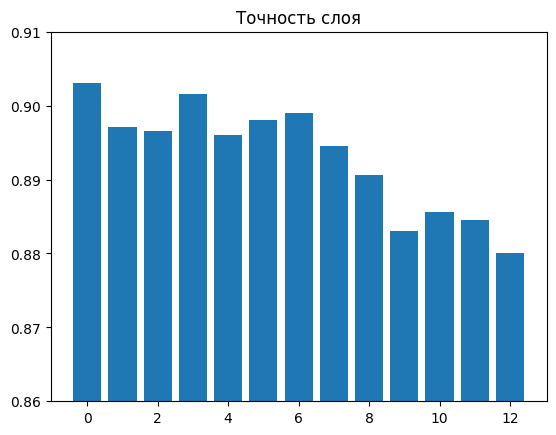

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
plt.ylim(0.86, 0.91)
plt.show()

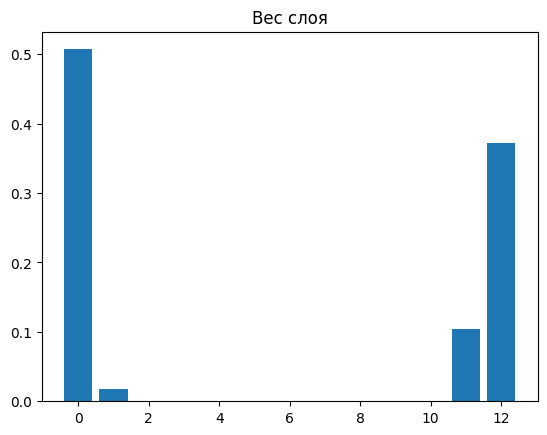

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder="/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.6981168831168831
CPU times: user 30.3 s, sys: 1.34 s, total: 31.6 s
Wall time: 41.2 s


## QP non sym

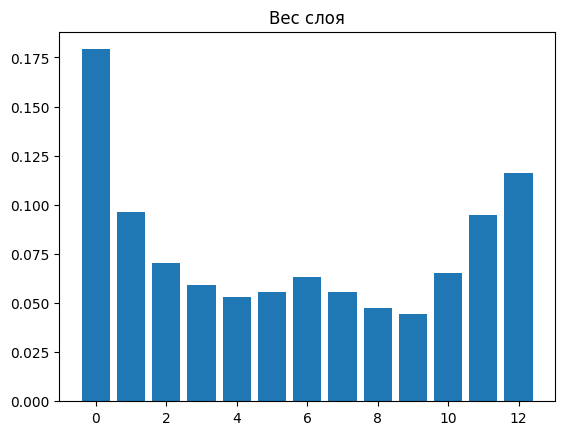

In [27]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [29]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [30]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder="/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

train.jsonl:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/365k [00:00<?, ?B/s]

main_score =  0.7121753246753247
CPU times: user 34.4 s, sys: 2.91 s, total: 37.3 s
Wall time: 51.8 s


## PCA_cluster

CLUSTERS:  [[1, 2, 3], [4, 5, 6, 7, 8], [9, 10, 11, 12], [0]]


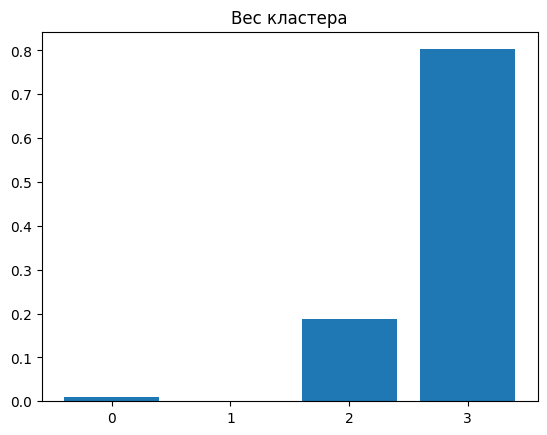

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA'
MODEL_NAME = "bert-base-uncased"
N_SENTENCES = 30_000
BATCH_GPU = 32

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA для задачи: Banking77Classification ===


  0%|          | 0/938 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_Banking77Classification.pt


In [ ]:
CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")

<ipython-input-38-a9b6d53f8894>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location="cpu")


In [ ]:
ckpt

{'components': tensor([[ 0.0042, -0.0039, -0.0007,  ...,  0.0517,  0.0087, -0.0039],
         [-0.0017, -0.0043, -0.0033,  ..., -0.0573, -0.0125, -0.0014],
         [-0.0031,  0.0002, -0.0014,  ...,  0.0100, -0.0297, -0.0117],
         ...,
         [-0.0020, -0.0043, -0.0006,  ...,  0.0511,  0.0052, -0.0170],
         [ 0.0023, -0.0059,  0.0068,  ...,  0.0205, -0.0524, -0.0151],
         [ 0.0038, -0.0054, -0.0002,  ...,  0.0580,  0.0269, -0.0136]]),
 'mean': tensor([-0.0052,  0.0118,  0.0086,  ..., -0.0603,  0.1073,  0.1111]),
 'clusters': [[1, 2, 3], [4, 5, 6, 7, 8], [9, 10, 11, 12], [0]],
 'weights': tensor([9.0860e-03, 1.7563e-22, 1.8833e-01, 8.0258e-01]),
 'hidden_size': 768}

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder="/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.6887662337662338


## PCA_qp

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
MODEL_NAME = "bert-base-uncased"
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA по отобранным слоям: [0, 1, 11, 12] ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_qadr_layers_Banking77Classification.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + "concat_pca_qp_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.6769805194805195


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.2, top_n = 13)

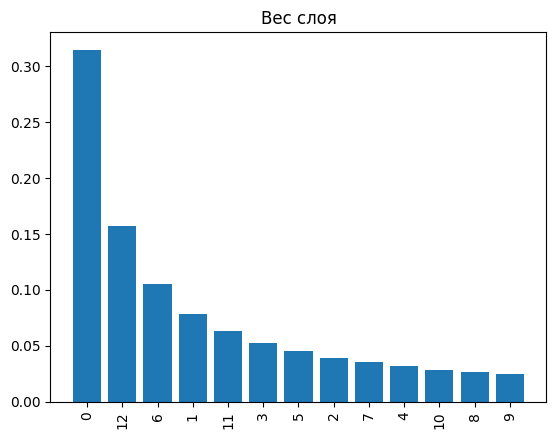

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder="/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

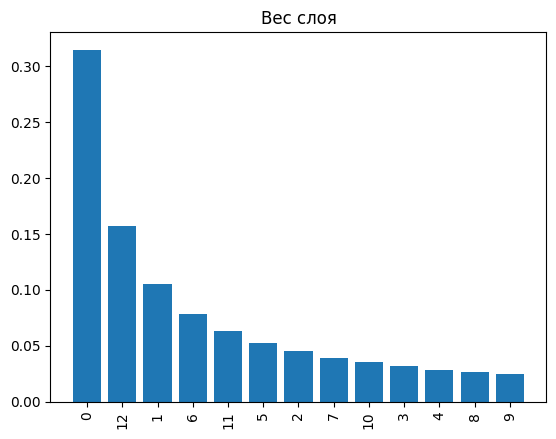

In [64]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [65]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder="/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_v3_Banking77Classification",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- Banking77Classification, s2s

main_score =  0.7175324675324676


## Общее сравнение

In [ ]:
dct_res = {}

with open("/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open("/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open("/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open("/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open("/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_qp_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open("/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_Banking77Classification/no_model_name_available/no_revision_available/Banking77Classification.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best


In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.634675,0.684123,0.698117,0.688766,0.676981,0.716396


# TweetSentimentExtractionClassification

In [31]:
task_names = ['TweetSentimentExtractionClassification']
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/'
sim_matr = load_res(PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0.  Параметры
# ─────────────────────────────────────────────────────────────
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'

# ─────────────────────────────────────────────────────────────
# 1.  Загружаем датасет с вашими сплитами
# ─────────────────────────────────────────────────────────────

ds = load_dataset("mteb/tweet_sentiment_extraction")


# Разбиваем train → 80% train + 20% validation
train_val = ds["train"].train_test_split(test_size=0.2, seed=42)
ds_splits = DatasetDict({
    "train":      train_val["train"],
    "dev": train_val["test"],
    "test":       ds["test"]
})

# ─────────────────────────────────────────────────────────────
# 4.  Прогоняем по слоям 0–12
# ─────────────────────────────────────────────────────────────
all_results = {}
for layer in range(13):
    print(f"\n>>> Layer {layer}")
    res = evaluate_layer(layer, part_val = 'dev', max_iter = 500)
    print(f"Accuracy: {res['accuracy']:.4f}")
    # print(res["report"])
    all_results[layer] = res
    save_res(all_results, PATH)

README.md:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/195k [00:00<?, ?B/s]


>>> Layer 0
Accuracy: 0.6882

>>> Layer 1
Accuracy: 0.6895

>>> Layer 2
Accuracy: 0.6836

>>> Layer 3
Accuracy: 0.6806

>>> Layer 4
Accuracy: 0.6789

>>> Layer 5
Accuracy: 0.6820

>>> Layer 6
Accuracy: 0.6851

>>> Layer 7
Accuracy: 0.6915

>>> Layer 8
Accuracy: 0.6987

>>> Layer 9
Accuracy: 0.6958

>>> Layer 10
Accuracy: 0.6962

>>> Layer 11
Accuracy: 0.6896

>>> Layer 12
Accuracy: 0.6866


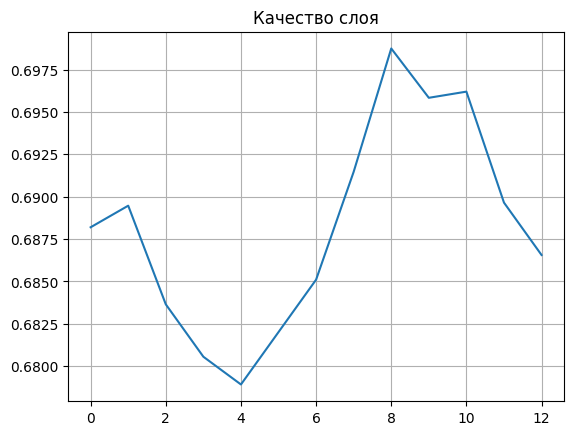

In [ ]:
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i['accuracy'] for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

main_score =  0.5183078664402943
CPU times: user 21 s, sys: 749 ms, total: 21.7 s
Wall time: 20.2 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5275042444821731
CPU times: user 28.3 s, sys: 253 ms, total: 28.6 s
Wall time: 18.8 s


## Взвешанное среднее

In [32]:
layer_acc = load_res(f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}')
acc = np.array([i['accuracy'] for i in  layer_acc.values()])

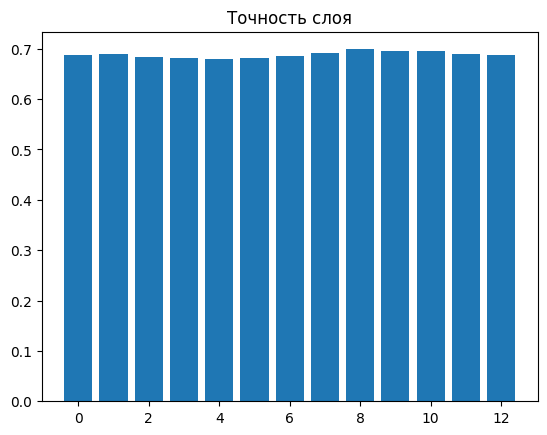

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.91)
plt.show()

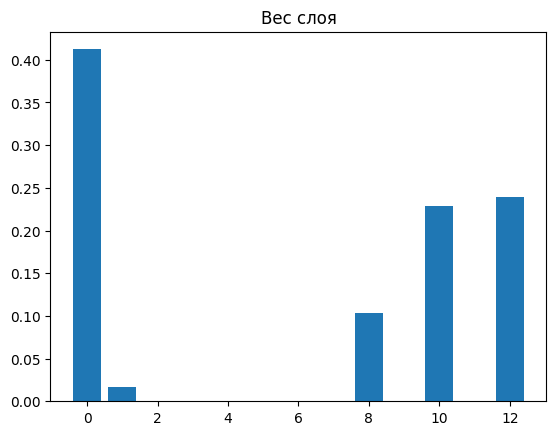

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

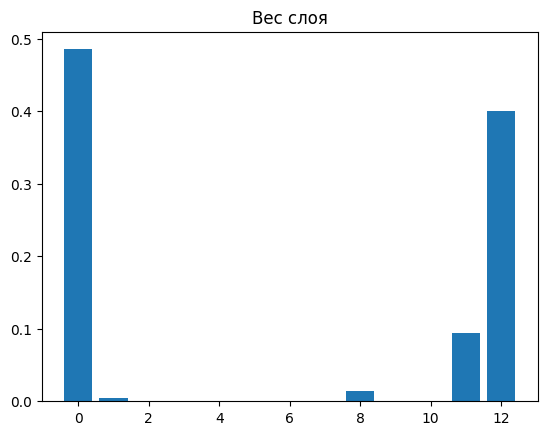

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5232597623089983
CPU times: user 21 s, sys: 134 ms, total: 21.2 s
Wall time: 9.96 s


## QP nonsym

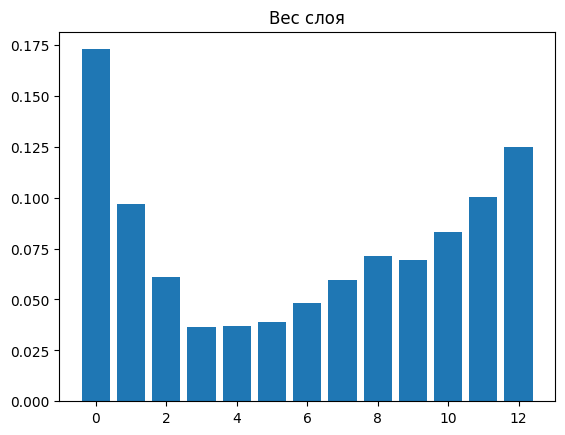

In [33]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [34]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [37]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

train.jsonl:   0%|          | 0.00/3.63M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/465k [00:00<?, ?B/s]

main_score =  0.5348330503678551
CPU times: user 20 s, sys: 156 ms, total: 20.1 s
Wall time: 13.1 s


## PCA_cluster

CLUSTERS:  [[1, 2, 3], [4, 5, 6, 7, 8], [9, 10, 11, 12], [0]]


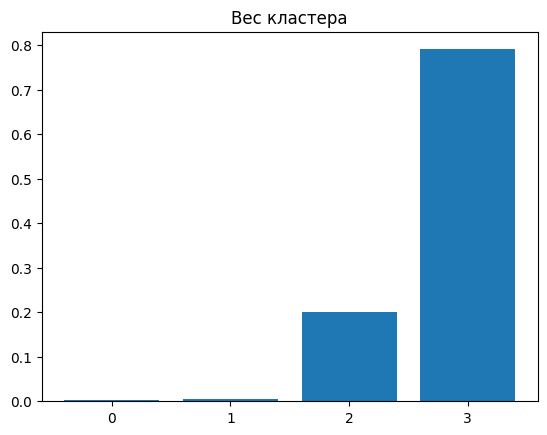

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA'
N_SENTENCES = 30_000
BATCH_GPU = 128
HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA для задачи: TweetSentimentExtractionClassification ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_TweetSentimentExtractionClassification.pt


In [ ]:
CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")

<ipython-input-92-a9b6d53f8894>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location="cpu")


In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.49934917940011314


## PCA QP

In [ ]:
PATH

'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_TweetSentimentExtractionClassification'

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
MODEL_NAME = "bert-base-uncased"
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.5255800792303339


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

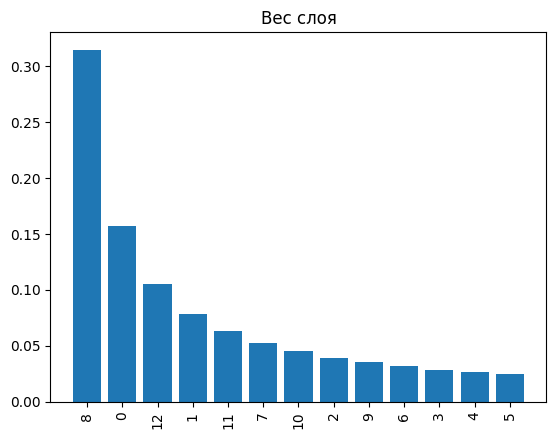

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.534974533106961


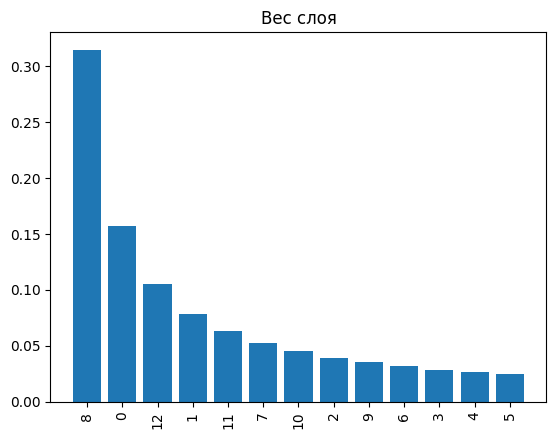

In [68]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [69]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Classification

- TweetSentimentExtractionClassification, s2s

main_score =  0.534974533106961


In [ ]:
task_names

['TweetSentimentExtractionClassification']

## Общее сравнение

In [ ]:
dct_res = {}

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_cluster'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_qp_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca_qp'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy
0,0.518308,0.527504,0.52326,0.499349,0.52558,0.534975


# NFCorpus

In [73]:
task_names = ['NFCorpus']
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/'
sim_matr = load_res(PATH + 'CKA.pkl')

## Качество отдельных слоев dev

In [ ]:
a = mteb.get_tasks(tasks = task_names)
a[0].metadata

TaskMetadata(dataset={'path': 'mteb/nfcorpus', 'revision': 'ec0fa4fe99da2ff19ca1214b7966684033a58814'}, name='NFCorpus', description='NFCorpus: A Full-Text Learning to Rank Dataset for Medical Information Retrieval', prompt={'query': 'Given a question, retrieve relevant documents that best answer the question'}, type='Retrieval', modalities=['text'], category='s2p', reference='https://www.cl.uni-heidelberg.de/statnlpgroup/nfcorpus/', eval_splits=['test'], eval_langs=['eng-Latn'], main_score='ndcg_at_10', date=None, domains=['Medical', 'Academic', 'Written'], task_subtypes=None, license=None, annotations_creators=None, dialect=None, sample_creation=None, bibtex_citation='\n@inproceedings{boteva2016,\n  author = {Boteva, Vera and Gholipour, Demian and Sokolov, Artem and Riezler, Stefan},\n  city = {Padova},\n  country = {Italy},\n  journal = {Proceedings of the 38th European Conference on Information Retrieval},\n  journal-abbrev = {ECIR},\n  title = {A Full-Text Learning to Rank Dataset

In [ ]:
ds = load_dataset("mteb/nfcorpus")

README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/7.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/748k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/810k [00:00<?, ?B/s]

In [ ]:
# Загружаем датасеты
ds = load_dataset("mteb/nfcorpus")
relevance_dev = ds["dev"]

queries = load_dataset("mteb/nfcorpus", name="queries", split="queries")
corpus  = load_dataset("mteb/nfcorpus", name="corpus",  split="corpus")

# Словари id → текст
qid2text = {q["_id"]: q["text"] for q in queries}
cid2text = {c["_id"]: c["text"] for c in corpus}

# Оставляем только id, участвующие в dev
query_ids_dev  = set([row["query-id"] for row in relevance_dev])
corpus_ids_dev = set([row["corpus-id"] for row in relevance_dev])

# Собираем тексты
queries_dev = [{"_id": qid, "text": qid2text[qid]} for qid in query_ids_dev if qid in qid2text]
corpus_dev  = [{"_id": cid, "text": cid2text[cid]} for cid in corpus_ids_dev if cid in cid2text]

queries.jsonl:   0%|          | 0.00/180k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

In [ ]:
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'


results = {}
for layer in range(13):
    print(f"→ Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    metrics = evaluate_layer_nfcorpus(
        encoder=encoder,
        queries=queries_dev,
        corpus=corpus_dev,
        relevance=relevance_dev,
        top_k=10
    )
    print(metrics)
    results[layer] = metrics
    save_res(results, PATH)

→ Layer 0
0.26851851851851855
→ Layer 1
0.3765432098765432
→ Layer 2
0.32098765432098764
→ Layer 3
0.23765432098765432
→ Layer 4
0.18518518518518517
→ Layer 5
0.16358024691358025
→ Layer 6
0.1419753086419753
→ Layer 7
0.1419753086419753
→ Layer 8
0.14814814814814814
→ Layer 9
0.1697530864197531
→ Layer 10
0.18518518518518517
→ Layer 11
0.2716049382716049
→ Layer 12
0.28703703703703703


In [ ]:
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)

all_results = []
for layer in range(13):
    print(f"\n>>> Layer {layer}")

    encoder = SingleLayerEncoder(layer)

    evaluation = mteb.MTEB(tasks=tasks)
    results = evaluation.run(
    encoder,
    output_folder=f'{layer}',
    verbosity=1,
    )
    all_results.append(results[0].scores['test'][0]['main_score'])

    print('main_score = ', results[0].scores['test'][0]['main_score'])


>>> Layer 0


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.09609

>>> Layer 1


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.12746

>>> Layer 2


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.09973

>>> Layer 3


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.06879

>>> Layer 4


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.04427

>>> Layer 5


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.03521

>>> Layer 6


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.03188

>>> Layer 7


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.03117

>>> Layer 8


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.02789

>>> Layer 9


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.02917

>>> Layer 10


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.03152

>>> Layer 11


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.04438

>>> Layer 12


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.05242


In [ ]:
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'
res = load_res(PATH)

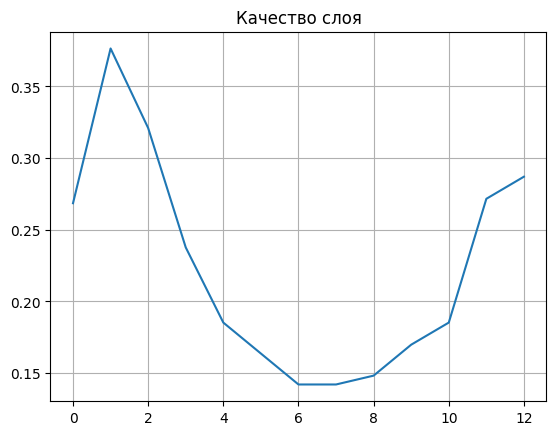

In [ ]:
plt.plot(list(res.values()), label = 'my_evaluate')
# plt.plot(mteb_acc, label = 'nteb_test')
plt.title('Качество слоя')
plt.grid()
# plt.legend()
plt.show()

In [ ]:
best_layer = np.argmax(list(res.values())).item()
best_layer

1

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.12746
CPU times: user 30.9 s, sys: 271 ms, total: 31.2 s
Wall time: 33 s


## Взвешанное среднее

In [74]:
layer_acc = load_res(f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}')
acc = np.array(list(layer_acc.values()))

In [ ]:
acc

array([0.26851852, 0.37654321, 0.32098765, 0.23765432, 0.18518519,
       0.16358025, 0.14197531, 0.14197531, 0.14814815, 0.16975309,
       0.18518519, 0.27160494, 0.28703704])

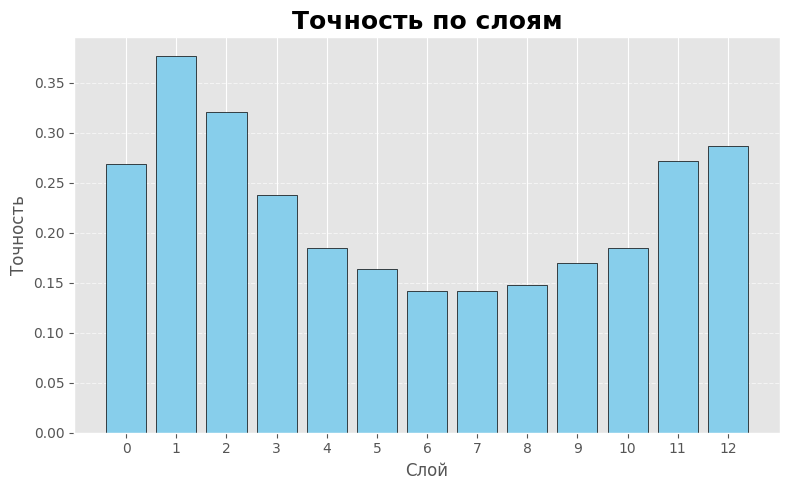

Изображение сохранено в: accuracy_layer_pretty.png


In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 5))

layers = np.arange(len(acc))

# Отрисовка столбцов с цветом и краями
bars = ax.bar(layers, acc, color='skyblue', edgecolor='black')

# Добавление подписей над каждым столбцом
# for bar in bars:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width() / 2, height + 0.002,
#             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Оформление графика
ax.set_title('Точность по слоям', fontsize=18, fontweight='bold')
ax.set_xlabel('Слой', fontsize=12)
ax.set_ylabel('Точность', fontsize=12)
# ax.set_ylim(0.80, 0.91)
ax.set_xticks(layers)
# ax.set_xticklabels([f'Слой {i}' for i in layers])
ax.set_xticklabels([f'{i}' for i in layers])

ax.grid(axis='y', linestyle='--', alpha=0.6)

# Сохранение изображения
output_path = "accuracy_layer_pretty.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Изображение сохранено в: {output_path}")

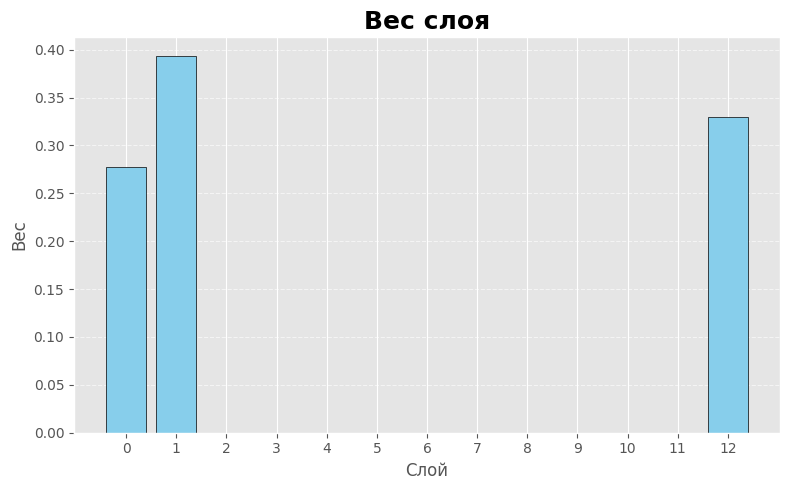

Изображение сохранено в: weights_layer_pretty.png


In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8, 5))

layers = np.arange(len(acc))

# Отрисовка столбцов с цветом и краями
bars = ax.bar(layers, final_weights, color='skyblue', edgecolor='black')

# Добавление подписей над каждым столбцом
# for bar in bars:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width() / 2, height + 0.002,
#             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Оформление графика
ax.set_title('Вес слоя', fontsize=18, fontweight='bold')
ax.set_xlabel('Слой', fontsize=12)
ax.set_ylabel('Вес', fontsize=12)
# ax.set_ylim(0.80, 0.91)
ax.set_xticks(layers)
# ax.set_xticklabels([f'Слой {i}' for i in layers])
ax.set_xticklabels([f'{i}' for i in layers])

ax.grid(axis='y', linestyle='--', alpha=0.6)

# Сохранение изображения
output_path = "weights_layer_pretty.png"
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()

print(f"Изображение сохранено в: {output_path}")

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.14164
CPU times: user 27.4 s, sys: 218 ms, total: 27.6 s
Wall time: 29.7 s


## QP nonsym

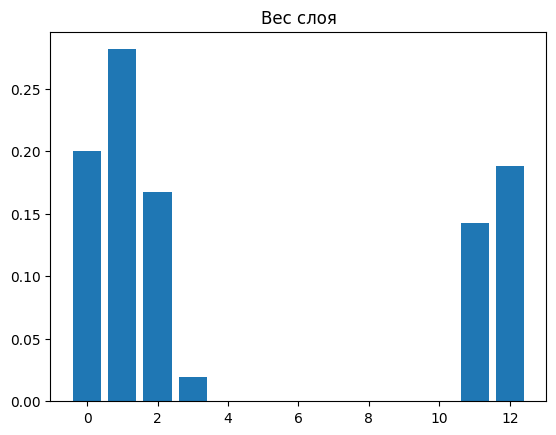

In [77]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


In [42]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

README.md:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/180k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/7.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/748k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/810k [00:00<?, ?B/s]

main_score =  0.12454
CPU times: user 25.4 s, sys: 285 ms, total: 25.7 s
Wall time: 36.3 s


## PCA cluster

CLUSTERS:  [[1, 2, 3], [4, 5, 6, 7, 8], [9, 10, 11, 12], [0]]


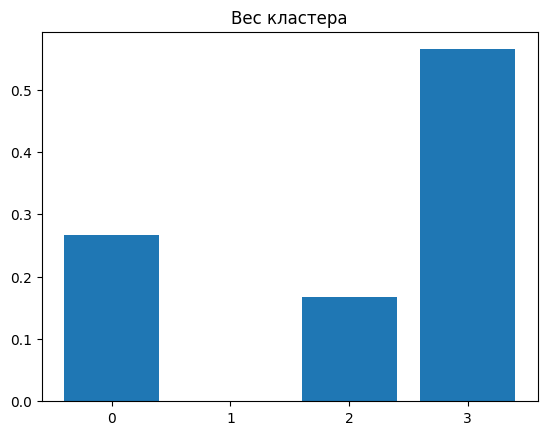

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA для задачи: NFCorpus ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_NFCorpus.pt


In [ ]:
CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")

<ipython-input-116-a9b6d53f8894>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location="cpu")


In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.1072


## PCA QP

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
MODEL_NAME = "bert-base-uncased"
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA по отобранным слоям: [0, 1, 12] ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_qadr_layers_NFCorpus.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.08551


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

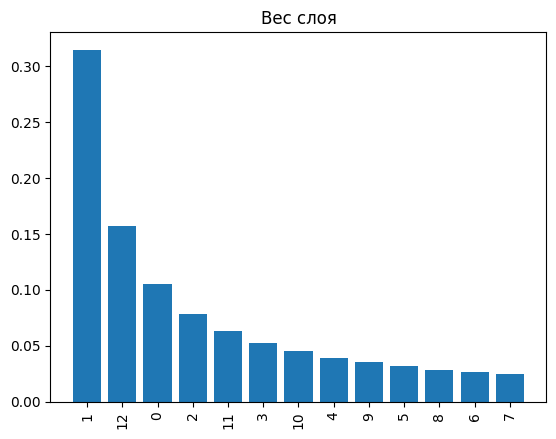

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

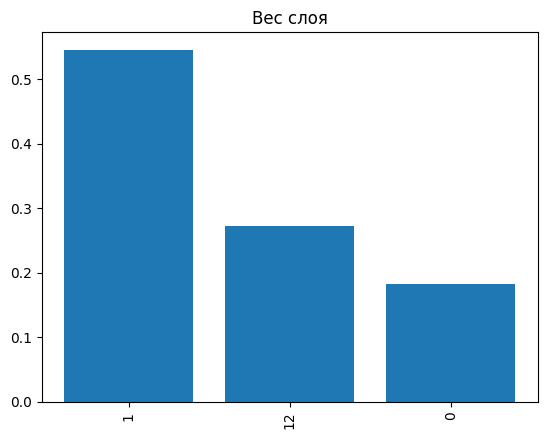

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 3)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

здесь чит, взял 3 вместо всех

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)

evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.14052


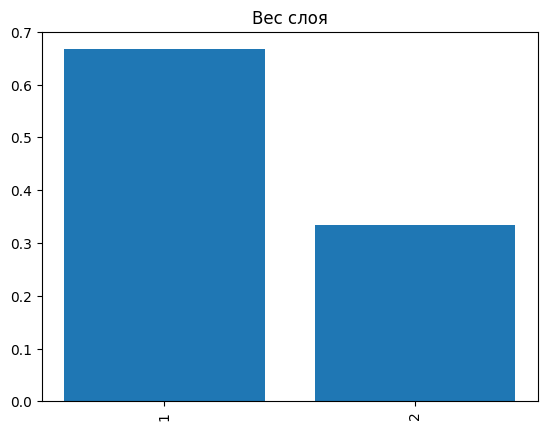

In [72]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [73]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)

evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- NFCorpus, s2p

main_score =  0.11816


## Общее сравнение

In [ ]:
f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json"

'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_NFCorpus/no_model_name_available/no_revision_available/NFCorpus.json'

In [ ]:
dct_res = {}

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca,greedy
0,0.05242,0.12746,0.14164,0.1072,0.09202


# QuoraRetrieval

In [78]:
task_names = ['QuoraRetrieval']
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/'
sim_matr = load_res(PATH + 'CKA.pkl')

In [ ]:
# tasks = mteb.get_tasks(
#     tasks=task_names,
#     languages=['eng'],            # только английский
# )

## Качество отдельных слоев на dev

In [ ]:
# Загружаем датасеты
ds = load_dataset("mteb/quora")
relevance_dev = ds["dev"]

queries = load_dataset("mteb/quora", name="queries", split="queries")
corpus  = load_dataset("mteb/quora", name="corpus",  split="corpus")

# Словари id → текст
qid2text = {q["_id"]: q["text"] for q in queries}
cid2text = {c["_id"]: c["text"] for c in corpus}

# Оставляем только id, участвующие в dev
query_ids_dev  = set([row["query-id"] for row in relevance_dev])
corpus_ids_dev = set([row["corpus-id"] for row in relevance_dev])

# Собираем тексты
queries_dev = [{"_id": qid, "text": qid2text[qid]} for qid in query_ids_dev if qid in qid2text]
corpus_dev  = [{"_id": cid, "text": cid2text[cid]} for cid in corpus_ids_dev if cid in cid2text]

README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

In [ ]:
# queries_dev

In [ ]:
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'


results = {}
for layer in range(13):
    print(f"→ Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    metrics = evaluate_layer_ndcg(
    encoder=encoder,
    queries=queries_dev,
    corpus=corpus_dev,
    relevance=relevance_dev,
    top_k=10
    )
    print(metrics)
    results[layer] = metrics
    save_res(results, PATH)

→ Layer 0
0.8843201830170687
→ Layer 1
0.9340758917976686
→ Layer 2
0.9330867904111386
→ Layer 3
0.9135288277006717
→ Layer 4
0.8987789181623419
→ Layer 5
0.8937456432329247
→ Layer 6
0.8757506941557047
→ Layer 7
0.8723347499991935
→ Layer 8
0.8516071436404214
→ Layer 9
0.8345822641149012
→ Layer 10
0.8691485332696502
→ Layer 11
0.8749782060563451
→ Layer 12
0.8846985728534641


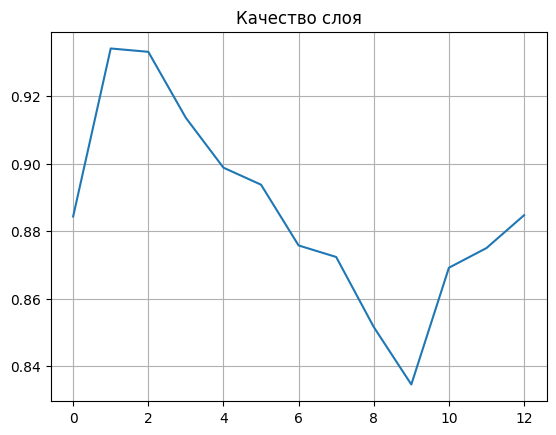

In [ ]:
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i.item() for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.61035
CPU times: user 19min 43s, sys: 50.6 s, total: 20min 33s
Wall time: 17min 58s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.71198
CPU times: user 19min 36s, sys: 41.4 s, total: 20min 17s
Wall time: 17min 50s


## Взвешанное среднее

In [79]:
layer_acc = load_res(f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}')
acc = np.array([i.item() for i in  layer_acc.values()])

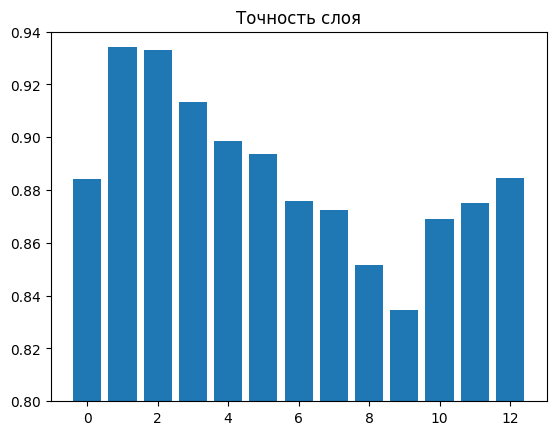

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
plt.ylim(0.80, 0.94)
plt.show()

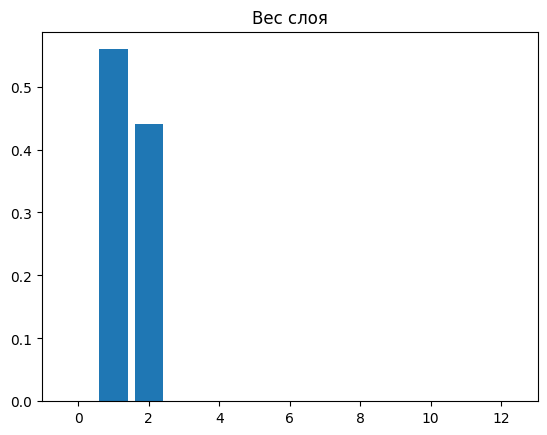

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

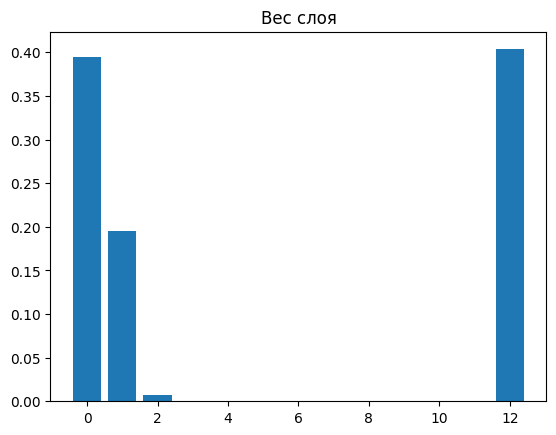

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.70384
CPU times: user 19min 48s, sys: 48.7 s, total: 20min 37s
Wall time: 17min 57s


## QP nonsym

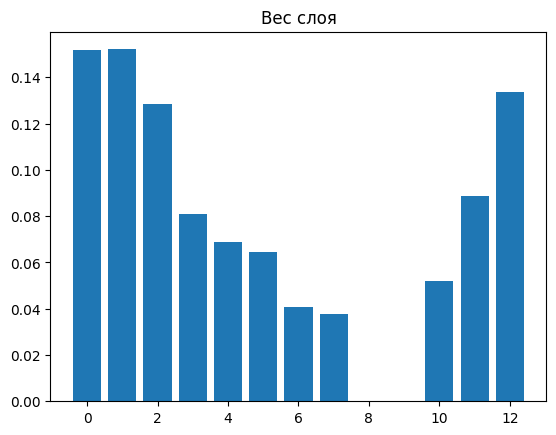

In [80]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [81]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

main_score =  0.71033
CPU times: user 20min 6s, sys: 45.6 s, total: 20min 52s
Wall time: 18min 21s


## PCA cluster

CLUSTERS:  [[1, 2, 3], [4, 5, 6, 7, 8], [9, 10, 11, 12], [0]]


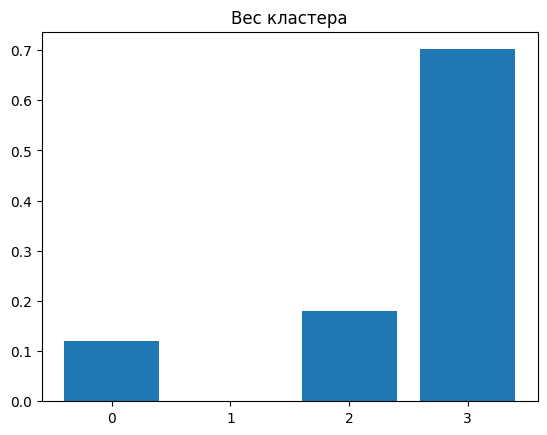

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA для задачи: QuoraRetrieval ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_QuoraRetrieval.pt


In [ ]:
CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")

<ipython-input-58-a9b6d53f8894>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CKPT_PATH, map_location="cpu")


In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.66426


## PCA QP

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
MODEL_NAME = "bert-base-uncased"
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]


=== Обучение PCA по отобранным слоям: [0, 1, 2, 12] ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/pca_qadr_layers_QuoraRetrieval.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

main_score =  0.67607


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

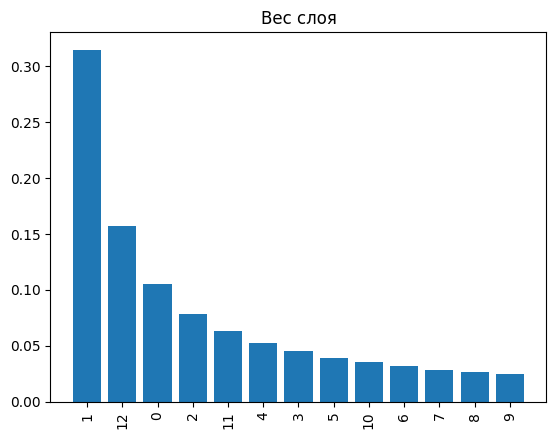

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

main_score =  0.71513


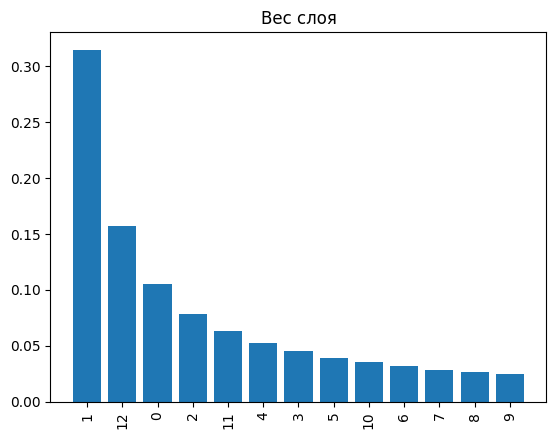

In [76]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [77]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

Retrieval

- QuoraRetrieval, s2s

README.md:   0%|          | 0.00/8.36k [00:00<?, ?B/s]

corpus.jsonl:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

queries.jsonl:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/453k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/930k [00:00<?, ?B/s]

main_score =  0.71513


## Общее сравнение

In [ ]:
f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json"

'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_QuoraRetrieval/no_model_name_available/no_revision_available/QuoraRetrieval.json'

In [ ]:
dct_res = {}

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca,greedy
0,0.61035,0.71198,0.70384,0.66426,0.71513


# STSBenchmark

In [51]:
task_names = ['STSBenchmark']
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/'
sim_matr = load_res(PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
ds = load_dataset("mteb/stsbenchmark-sts")
dev = ds["validation"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.67k [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

In [ ]:
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'

results = {}
for layer in range(13):
    print(f"\n>>> Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    spearman = evaluate_layer_spearman(encoder, dev)
    print(f"Spearman = {spearman:.4f}")

    results[layer] = spearman
    save_res(results, PATH)


>>> Layer 0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Spearman = 0.6026

>>> Layer 1
Spearman = 0.6927

>>> Layer 2
Spearman = 0.6731

>>> Layer 3
Spearman = 0.6558

>>> Layer 4
Spearman = 0.6352

>>> Layer 5
Spearman = 0.6346

>>> Layer 6
Spearman = 0.6233

>>> Layer 7
Spearman = 0.6234

>>> Layer 8
Spearman = 0.6141

>>> Layer 9
Spearman = 0.5855

>>> Layer 10
Spearman = 0.5903

>>> Layer 11
Spearman = 0.5994

>>> Layer 12
Spearman = 0.5932


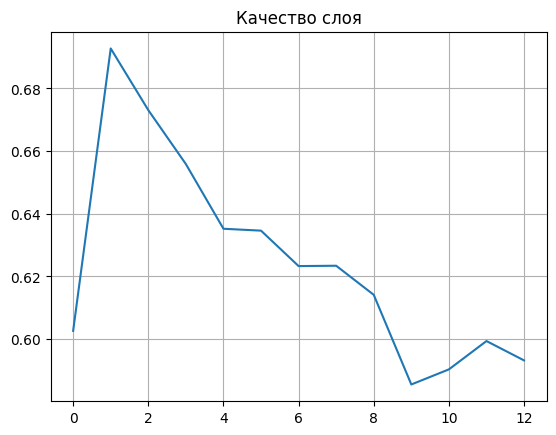

In [ ]:
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i.item() for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

## среднее последнего слоя

In [ ]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.4729085127576536
CPU times: user 3.25 s, sys: 93.8 ms, total: 3.34 s
Wall time: 5.24 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5813718552329861
CPU times: user 3.07 s, sys: 82.1 ms, total: 3.16 s
Wall time: 4.2 s


## Взвешанное среднее

In [52]:
layer_acc = load_res(f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}')
acc = np.array([i.item() for i in  layer_acc.values()])

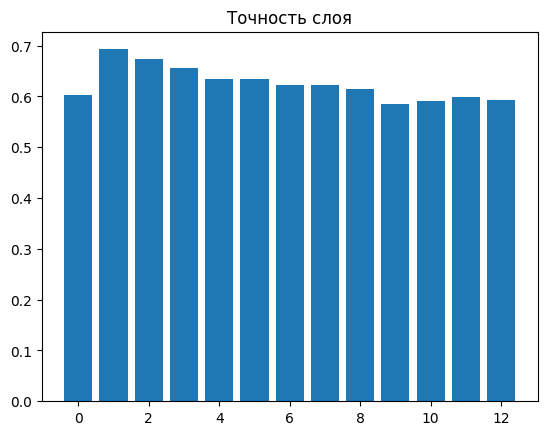

In [ ]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.94)
plt.show()

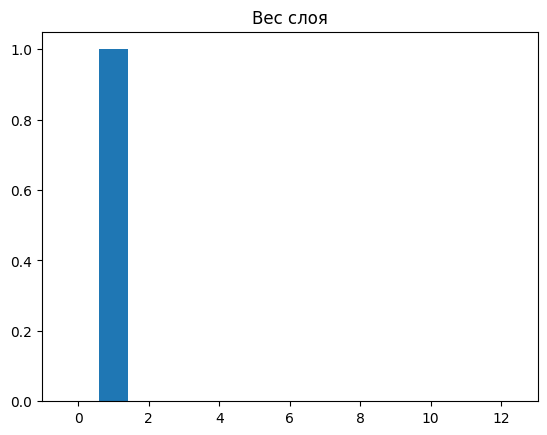

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

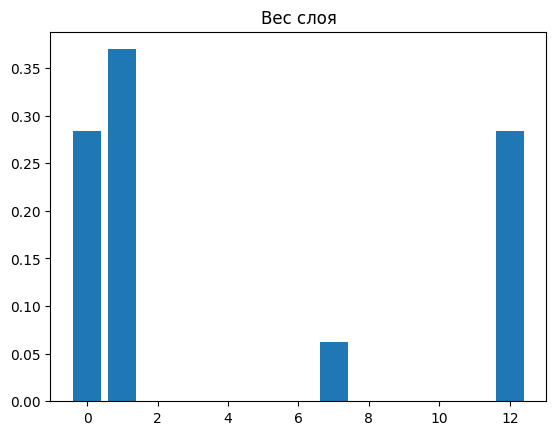

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5943699676073841
CPU times: user 3.18 s, sys: 86.4 ms, total: 3.27 s
Wall time: 4.34 s


## QP nonsym

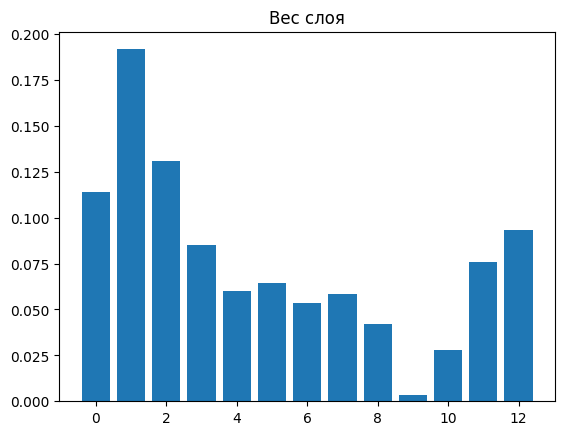

In [53]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()


In [54]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

main_score =  0.593309162939127
CPU times: user 3.58 s, sys: 148 ms, total: 3.73 s
Wall time: 8.39 s


## PCA cluster

CLUSTERS:  [[1, 2, 3], [4, 5, 6, 7, 8], [9, 10, 11, 12], [0]]


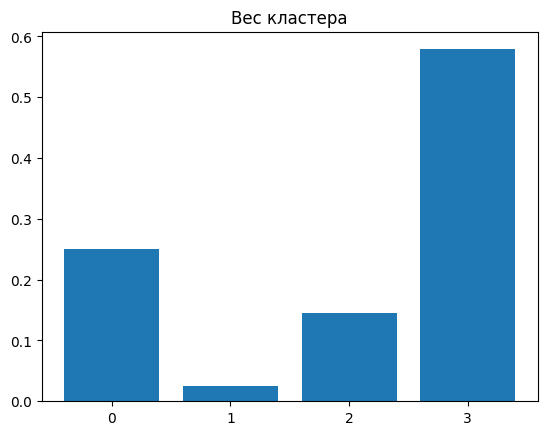

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

README.md:   0%|          | 0.00/41.1k [00:00<?, ?B/s]


=== Обучение PCA для задачи: STSBenchmark ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_STSBenchmark.pt


In [ ]:
CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.6045445885548576


## PCA QP

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
MODEL_NAME = "bert-base-uncased"
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA по отобранным слоям: [0, 1, 7, 12] ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_qadr_layers_STSBenchmark.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5906002704946626


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

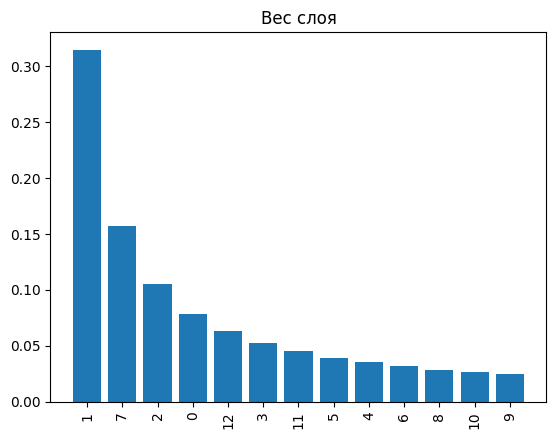

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5959177891587375


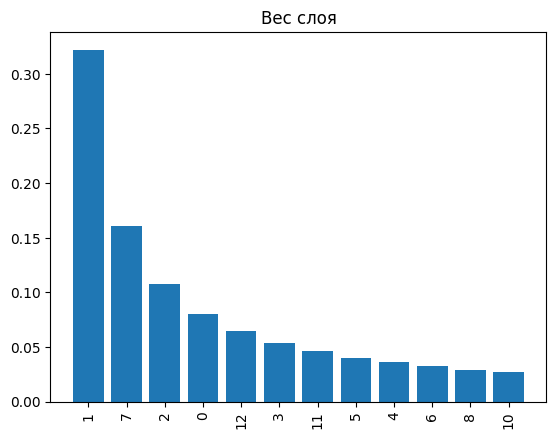

In [56]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [57]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_v3_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

STS

- STSBenchmark, s2s

main_score =  0.5953913614468661


## Общее сравнение

In [ ]:
f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json"

'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_STSBenchmark/no_model_name_available/no_revision_available/STSBenchmark.json'

In [ ]:
dct_res = {}

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca,greedy
0,0.472909,0.581372,0.594371,0.606579,0.595918


In [ ]:
'SprintDuplicateQuestions',     # Pair Classification
    'TwitterSemEval2015',           # Pair Classification

# SprintDuplicateQuestions

In [66]:
task_names = ['SprintDuplicateQuestions']
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/'
sim_matr = load_res(PATH + 'CKA.pkl')

## Качество отдельных слоев на dev

In [ ]:
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)

In [ ]:
tasks[0].load_data()

validation.json.gz:   0%|          | 0.00/897k [00:00<?, ?B/s]

test.json.gz:   0%|          | 0.00/901k [00:00<?, ?B/s]

In [ ]:
dataset = load_dataset("mteb/sprintduplicatequestions-pairclassification", split="validation")

README.md:   0%|          | 0.00/7.69k [00:00<?, ?B/s]

In [ ]:
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'


results = {}

for layer in range(13):
    print(f"\n>>> Layer {layer}")
    encoder = SingleLayerEncoder(layer)
    ap = evaluate_layer_ap(encoder, dataset)
    print(f"AP = {ap:.4f}")
    results[layer] = ap
    save_res(results, PATH)


>>> Layer 0
AP = 0.7062

>>> Layer 1
AP = 0.7502

>>> Layer 2
AP = 0.6825

>>> Layer 3
AP = 0.6343

>>> Layer 4
AP = 0.5117

>>> Layer 5
AP = 0.4635

>>> Layer 6
AP = 0.4032

>>> Layer 7
AP = 0.3961

>>> Layer 8
AP = 0.3158

>>> Layer 9
AP = 0.2763

>>> Layer 10
AP = 0.2752

>>> Layer 11
AP = 0.2475

>>> Layer 12
AP = 0.2584


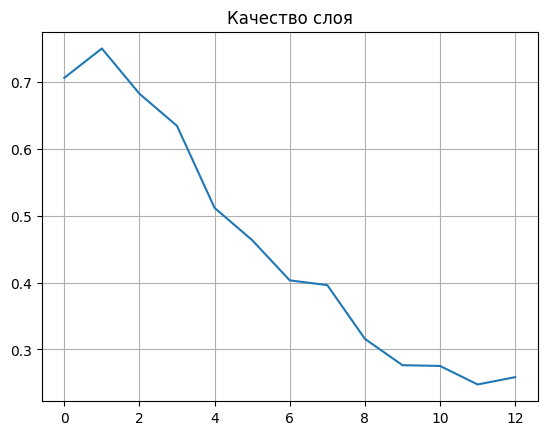

In [25]:
PATH = f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}'

res = load_res(PATH)
res =np.array([i.item() for i in res.values()])
plt.plot(res)
plt.title('Качество слоя')
plt.grid()
plt.show()

In [ ]:
best_layer = np.argmax(res)

In [30]:
# %%time
# mteb_eval = []
# tasks = mteb.get_tasks(
#     tasks=task_names,
#     languages=['eng'],            # только английский
# )


# for i in range(13):
#   encoder = SingleLayerEncoder(i)
#   evaluation = mteb.MTEB(tasks=tasks)
#   results = evaluation.run(
#       encoder,
#       output_folder=f"{i}",
#       verbosity=1
#   )
#   mteb_eval.append(results[0].scores['test'][0]['main_score'])
#   print(mteb_eval[-1])

In [31]:
# plt.plot(res, label = 'mine')
# plt.plot(mteb_eval, label = 'mteb')
# plt.title('Качество слоя')
# plt.grid()
# plt.legend()
# plt.show()

## среднее последнего слоя

In [68]:
%%time
encoder = MultiLayerEncoderMean()
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.368088
CPU times: user 719 ms, sys: 89 ms, total: 808 ms
Wall time: 2.36 s


## Лучший слой dev

In [ ]:
%%time
encoder = SingleLayerEncoder(best_layer)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}",
    verbosity=1
)
print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.785121093301994
CPU times: user 13.6 s, sys: 577 ms, total: 14.2 s
Wall time: 15.2 s


## Взвешанное среднее

In [67]:
layer_acc = load_res(f'/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_{task_names[0]}')
acc = np.array([i.item() for i in  layer_acc.values()])

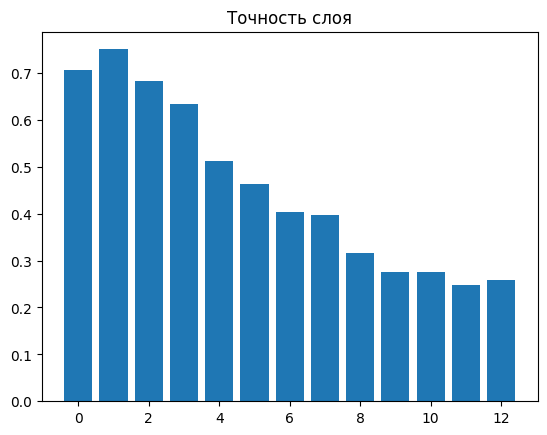

In [57]:
plt.bar(np.arange(len(acc)), acc)
plt.title('Точность слоя')
# plt.ylim(0.80, 0.94)
plt.show()

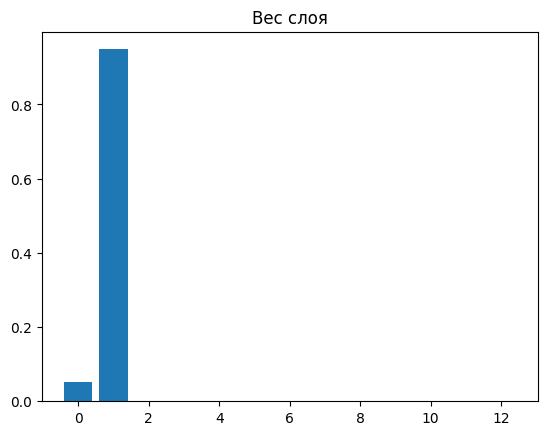

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.1)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

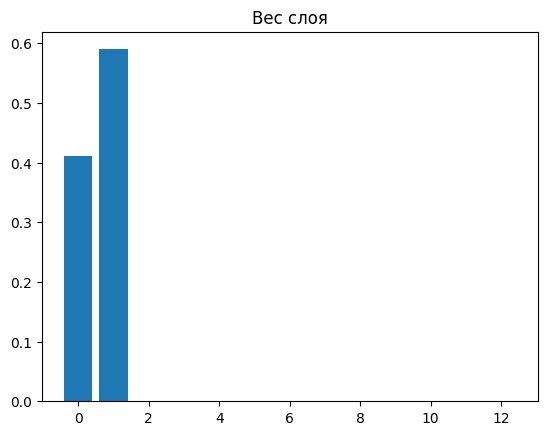

In [ ]:
final_weights = qadr_solve(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [ ]:
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()

In [ ]:
%%time

encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.7817502121176997
CPU times: user 16.5 s, sys: 596 ms, total: 17.1 s
Wall time: 18.1 s


## QP nonsym

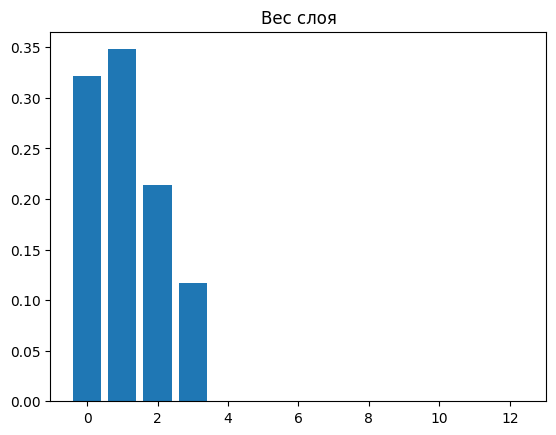

In [72]:
final_weights = qadr_solve_greedy(acc, sim_matr, lmbd = 0.5)

plt.bar(np.arange(len(acc)), final_weights)
plt.title('Вес слоя')
plt.show()

In [59]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

validation.json.gz:   0%|          | 0.00/897k [00:00<?, ?B/s]

test.json.gz:   0%|          | 0.00/901k [00:00<?, ?B/s]

main_score =  0.7721033213949456
CPU times: user 16.7 s, sys: 984 ms, total: 17.7 s
Wall time: 21 s


In [71]:
%%time
THRESH = 0.001

weights_idx = np.where((final_weights > THRESH))[0]
final_acc = final_weights[weights_idx]
final_acc = final_acc / final_acc.sum()


encoder = MultiLayerEncoderWeighted(
    model_name=MODEL_NAME,
    layer_indices=weights_idx,
    layer_weights=final_acc
)
tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.7847084858786781
CPU times: user 15.7 s, sys: 844 ms, total: 16.6 s
Wall time: 17.7 s


## PCA cluster

CLUSTERS:  [[1, 2, 3], [4, 5, 6, 7, 8], [9, 10, 11, 12], [0]]


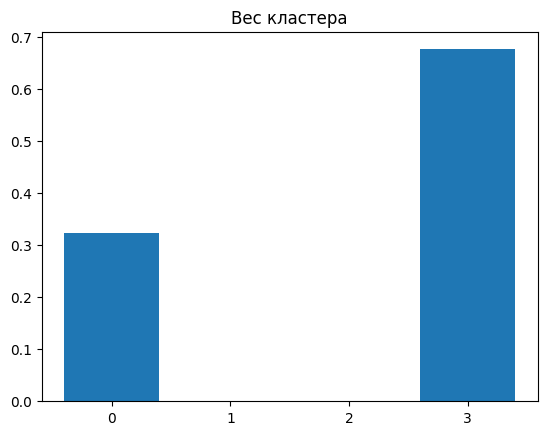

In [ ]:
cluster_weights = np.array([
        final_weights[cluster].mean()
        for cluster in CLUSTERS
    ], dtype=np.float32)

cluster_weights /= cluster_weights.sum()

print('CLUSTERS: ', CLUSTERS)
plt.bar(np.arange(len(cluster_weights)), cluster_weights)
plt.title('Вес кластера')
plt.xticks([0,1,2,3])
plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA'
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
CONCAT_DIM = HIDDEN_SIZE * len(CLUSTERS)
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Цикл по типам задач и их весам
# ─────────────────────────────────────────────────────────────

print(f"\n=== Обучение PCA для задачи: {task_names[0]} ===")

# Нормализация весов (на всякий случай)
weights = np.array(cluster_weights, dtype=np.float32)
weights = weights / weights.sum()
WEIGHTS = torch.tensor(weights)

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, 0).float()  # [13, B, L, H]

        vecs = []
        for idx, cl in enumerate(CLUSTERS):
            v = h[cl].mean(0)                                # [B,L,H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B,L,1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)
            vecs.append(sent * WEIGHTS[idx].sqrt())          # √w * h̄

        concat = torch.cat(vecs, -1).cpu().numpy()
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохраняем результат для задачи
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "clusters":   CLUSTERS,
    "weights":    WEIGHTS,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_divercity_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")

README.md:   0%|          | 0.00/41.1k [00:00<?, ?B/s]


=== Обучение PCA для задачи: SprintDuplicateQuestions ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_SprintDuplicateQuestions.pt


In [ ]:
# CKPT_PATH  = f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_divercity_{task_names[0]}.pt"
# ckpt = torch.load(CKPT_PATH, map_location="cpu")

In [ ]:
encoder = MultiLayerEncoder(
    clusters       = ckpt['clusters'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    weights        = ckpt['weights']
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.8069866091285373


## PCA QP

In [ ]:
# ─────────────────────────────────────────────────────────────
# 0. Параметры
# ─────────────────────────────────────────────────────────────
MODEL_NAME = "bert-base-uncased"
N_SENTENCES = 30_000
BATCH_GPU = 128

HIDDEN_SIZE = 768
OUT_DIM = 768
COLLECT = max(OUT_DIM, 2048)

# отобранные слои и их веса
selected_layers = weights_idx
final_acc = final_acc
final_acc /= final_acc.sum()  # нормализация
layer_weights = torch.tensor(final_acc, dtype=torch.float32)

# ─────────────────────────────────────────────────────────────
# 1. Корпус
# ─────────────────────────────────────────────────────────────
ds = load_dataset("allenai/c4", "en", split="train", streaming=True)
texts = [ex["text"] for ex in ds.shuffle(buffer_size=N_SENTENCES, seed=42).take(N_SENTENCES)]

# ─────────────────────────────────────────────────────────────
# 2. Модель
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
mdl = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True).to(device).eval()

# ─────────────────────────────────────────────────────────────
# 3. Обучение PCA на выбранных слоях
# ─────────────────────────────────────────────────────────────
print(f"\n=== Обучение PCA по отобранным слоям: {selected_layers.tolist()} ===")

ipca = IncrementalPCA(n_components=OUT_DIM, batch_size=512)
buffer, buf_len = [], 0

def flush_to_pca(buffer, buf_len):
    if buf_len:
        ipca.partial_fit(np.vstack(buffer))
        torch.cuda.empty_cache()
    return [], 0

with torch.no_grad():
    for s in tqdm(range(0, len(texts), BATCH_GPU)):
        batch = texts[s:s + BATCH_GPU]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN).to(device)
        outs = mdl(**enc)
        h = torch.stack(outs.hidden_states, dim=0).float()  # [L, B, T, H]

        vecs = []
        for i, layer_idx in enumerate(selected_layers):
            v = h[layer_idx]                                 # [B, T, H]
            mask = enc.attention_mask.unsqueeze(-1).float()  # [B, T, 1]
            sent = (v * mask).sum(1) / mask.sum(1).clamp(min=1e-9)  # [B, H]
            sent = sent * layer_weights[i].sqrt()
            vecs.append(sent)

        concat = torch.cat(vecs, dim=-1).cpu().numpy()       # [B, len*H]
        buffer.append(concat)
        buf_len += concat.shape[0]

        if buf_len >= COLLECT:
            buffer, buf_len = flush_to_pca(buffer, buf_len)

        del outs, h, enc, concat
        gc.collect()

# финальный сброс
buffer, buf_len = flush_to_pca(buffer, buf_len)

# ─────────────────────────────────────────────────────────────
# 4. Сохранение PCA
# ─────────────────────────────────────────────────────────────
ckpt = {
    "components": torch.tensor(ipca.components_, dtype=torch.float32),
    "mean":       torch.tensor(ipca.mean_,       dtype=torch.float32),
    "layers":     selected_layers.tolist(),
    "weights":    layer_weights,
    "hidden_size": HIDDEN_SIZE,
}
out_path = os.path.join(PATH, f"pca_qadr_layers_{task_names[0]}.pt")
torch.save(ckpt, out_path)
print(f"✓ PCA сохранена: {out_path}")


=== Обучение PCA по отобранным слоям: [0, 1] ===


  0%|          | 0/235 [00:00<?, ?it/s]

✓ PCA сохранена: /content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/PCA/pca_qadr_layers_SprintDuplicateQuestions.pt


In [ ]:
encoder = SelectedLayersPCAEncoder(
    layers         = ckpt['layers'],
    weights        = ckpt['weights'],
    pca_components = ckpt['components'],
    pca_mean       = ckpt['mean'],
    pooling        = 'mean',
    model_name     = MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder = BASE_PATH + f"concat_pca_qp_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.8263437603388462


## Greedy

In [ ]:
selected, weights = greedy_layer_selection(acc, sim_matr, lmbd=0.5, top_n = 13)

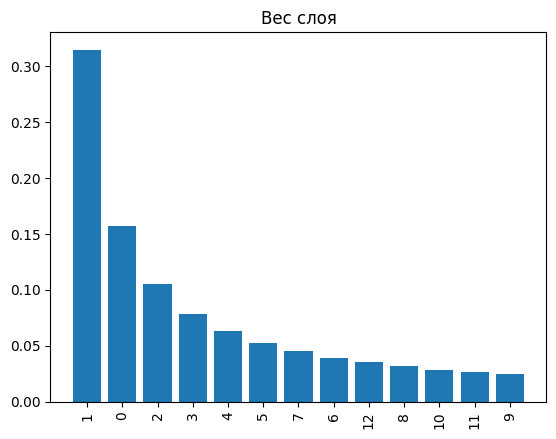

In [ ]:
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [ ]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}",
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.7138447330462799


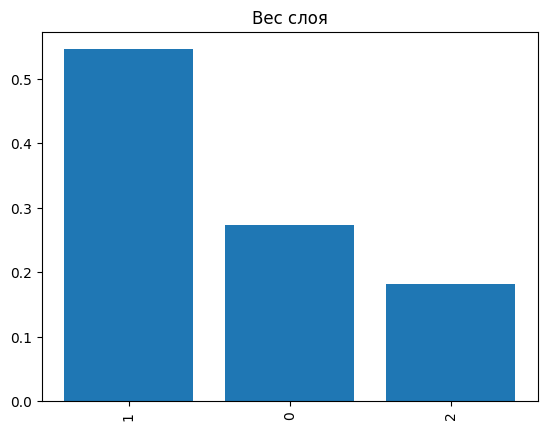

In [60]:
selected, weights = greedy_layer_selection_v3(acc, sim_matr, lmbd=0.5)
x = np.arange(len(selected))
plt.bar(x, weights)
plt.title('Вес слоя')
plt.xticks(x, selected, rotation='vertical')
plt.show()

In [61]:
encoder = SelectedLayersEncoder(
    selected_layers=selected,
    layer_weights=weights,
    pooling="mean",                # или "cls"
    model_name=MODEL_NAME
)

tasks = mteb.get_tasks(
    tasks=task_names,
    languages=['eng'],            # только английский
)
evaluation = mteb.MTEB(tasks=tasks)
results = evaluation.run(
    encoder,
    output_folder=f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_v3_{task_names[0]}",
    # output_folder = 'лдпkдf',
    verbosity=1
)

print('main_score = ', results[0].scores['test'][0]['main_score'])

───────────────────────────────────────────────── Selected tasks  ─────────────────────────────────────────────────

PairClassification

- SprintDuplicateQuestions, s2s

main_score =  0.7820192213704965


## Общее сравнение

In [ ]:
f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json"

In [ ]:
dct_res = {}

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['last_mean'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['best_layer'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['weighted_mean_qp'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['concat_pca'] = best

with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_{task_names[0]}/no_model_name_available/no_revision_available/{task_names[0]}.json") as f:
  best = json.load(f)['scores']['test'][0]['main_score']
  dct_res['greedy'] = best

In [ ]:
pd.DataFrame(dct_res, index = [0])

,last_mean,best_layer,weighted_mean_qp,concat_pca,greedy
0,0.368088,0.785121,0.78175,0.803311,0.713845


In [ ]:
from google.colab import runtime
runtime.unassign()

# Результаты по всем задачам

In [60]:
def load_row(task_name):

  dct_res = {}

  with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/last_mean_mask_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['last_mean'] = best

  with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/best_dev_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['best_layer'] = best

  with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_mean_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['weighted_mean_qp'] = best

  with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_cluster_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['concat_pca_cluster'] = best

  with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/concat_pca_qp_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['concat_pca_qp'] = best

  with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/greedy_v3_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['greedy'] = best

  with open(f"/content/drive/MyDrive/PTLS/NLP/BERT_BASE_UNCASED_SIM/layer_qp_nonsym_{task_name}/no_model_name_available/no_revision_available/{task_name}.json") as f:
    best = json.load(f)['scores']['test'][0]['main_score']
    dct_res['qp_nonsym'] = best

  return dct_res

In [82]:
task_names = ['Banking77Classification', 'TweetSentimentExtractionClassification', 'NFCorpus', 'QuoraRetrieval', 'STSBenchmark', 'SprintDuplicateQuestions']
# task_names = ['Banking77Classification', 'TweetSentimentExtractionClassification', 'NFCorpus', 'STSBenchmark', 'SprintDuplicateQuestions']

In [83]:
all_res = []
for task in task_names:
  all_res.append(load_row(task))

In [84]:
df = pd.DataFrame(all_res, index=task_names)

In [85]:
df

,last_mean,best_layer,weighted_mean_qp,concat_pca_cluster,concat_pca_qp,greedy,qp_nonsym
Banking77Classification,0.634675,0.684123,0.698117,0.688766,0.676981,0.717532,0.712175
TweetSentimentExtractionClassification,0.518308,0.527504,0.523260,0.499349,0.525580,0.534975,0.534833
NFCorpus,0.052420,0.127460,0.141640,0.107200,0.085510,0.118160,0.124540
QuoraRetrieval,0.610350,0.711980,0.703840,0.664260,0.676070,0.715130,0.710330
STSBenchmark,0.472909,0.581372,0.594370,0.604545,0.590600,0.595391,0.593309
SprintDuplicateQuestions,0.368088,0.785121,0.781750,0.806987,0.826344,0.782019,0.772103


In [86]:
df.to_csv(BASE_PATH +'BERT_final_results_1.csv')